# Задача декодировки изображений



Дана выборка

Выборка состоит из трех объектов: $X_{train}$, $Y_{train}$, $X_{test}$

$Y_{train}$ - изображение (пиксель кодируется черно-белой компонентой изображения), $X_{train}$ `[286, 604, 35]`- признаки, соответствующие этому изображению. (элемент $X[i,j]$ соответствует набору признаков для пикселя $Y[i,j]$).

Требуется:

1. Провести отбор наиболее значимых признаков и построить регрессию $X\rightarrow Y$
2. Проинтерпетировать признаки (каждый признак является функцией, возможно нелинейной, от значения пикселя)
3. Получить изображение по $X_{test}$ (Ожидается, что регрессия на $X_{train}$, $Y_{train}$ даст $R^2>0.85$).


In [18]:
magic_const = 35

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

from statsmodels.regression.linear_model import OLS

X_train = np.load('/content/drive/MyDrive/Colab Notebooks/regression_x_train.npy')
y_train = np.load('/content/drive/MyDrive/Colab Notebooks/regression_y_train.npy')

Посмотрим на массив таргетов

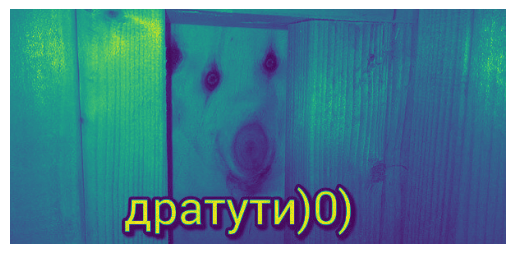

In [59]:
plt.imshow(y_train)
plt.axis('off');

In [60]:
#cмотрим на признаки
res = []
for i in range(magic_const):
    feat, counter = np.unique(X_train[:,:,i], return_counts=True)
    res.append(counter)
    print(feat[0], counter)
        
print(res)

0.4967141530112327 [164397   8347]
-0.13826430117118466 [89102 83642]
0.6476885381006925 [91989 80755]
1.5230298564080254 [8347    1    1 ...    1    1    1]
-0.23415337472333597 [8347    1    1 ...    1    1    1]
-0.07024108708475416 [164397   8347]
0.47376384465221744 [89102 83642]
0.23023041874587263 [91989 80755]
-0.14084231578048562 [8347    1    1 ...    1    1    1]
0.1627680130757894 [8347    1    1 ...    1    1    1]
5.447335223145896 [164397   8347]
14.85883488891553 [164397   8347]
28.87405402738814 [164397   8347]
962.8718863692098 [164397   8347]
36.13914940471159 [89102 83642]
17.174595632318848 [89102 83642]
91.76644248291785 [89102 83642]
87.47657112101957 [89102 83642]
10.612537798017986 [91989 80755]
61.46424059746372 [91989 80755]
180.99567815468586 [91989 80755]
76.60516102097486 [91989 80755]
3.0080508384700395 [8347    1    1 ...    1    1    1]
62.62235226566029 [8347    1    1 ...    1    1    1]
45.448239581260914 [8347    1    1 ...    1    1    1]
64.481856

Потом выкинем последние 5 признаков, так как они имеют 1 уникальное значение, а значит не помогают делить выборку, не несут информации.

In [61]:
X_train.shape

(286, 604, 35)

Давайте прогоним [корреляции Пирсона](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)

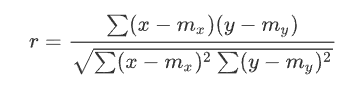

In [28]:
np.set_printoptions(precision=3)

In [62]:
np.array([sps.pearsonr(X_train[:,:,i].flatten(), y_train.flatten()).statistic for i in range(magic_const)])

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


array([-0.432, -0.588,  0.774,  0.211,  0.523, -0.432, -0.588,  0.774,
        0.211,  0.523, -0.432, -0.432, -0.432, -0.432, -0.588, -0.588,
       -0.588, -0.588,  0.774,  0.774,  0.774,  0.774,  0.001,  0.001,
        0.001,  0.001,  0.334,  0.334,  0.334,  0.334,    nan,    nan,
          nan,    nan,    nan])

Итого у нас 7 разных видов корреляции. Значит, дублирующиеся признаки можно пока удалить. Скачаем тест

In [53]:
test = np.load('/content/drive/MyDrive/Colab Notebooks/regression_x_test.npy')

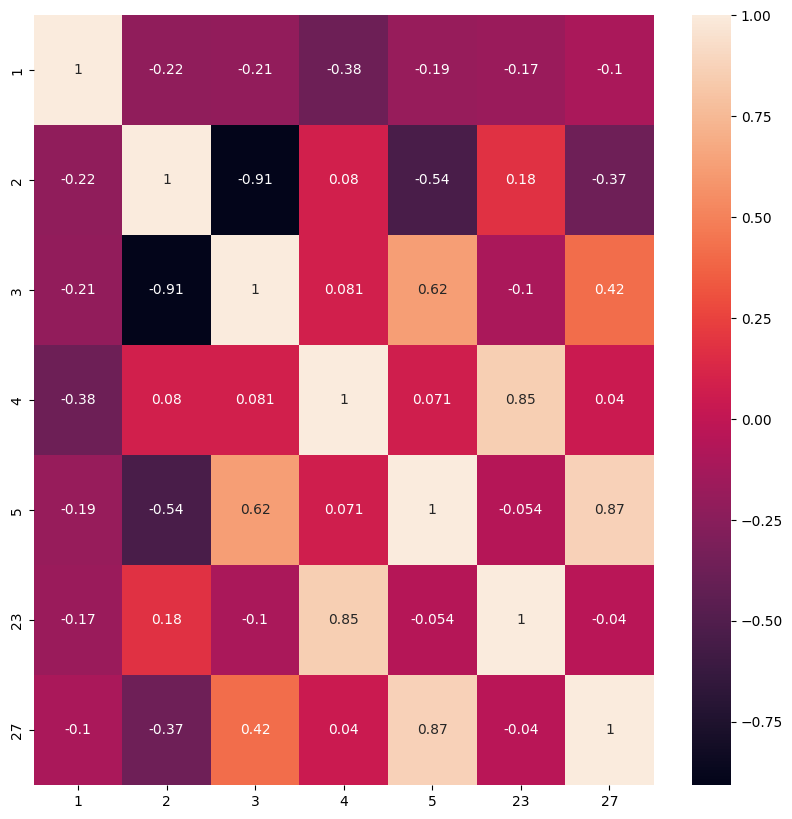

In [64]:
X = X_train.reshape(-1, 35)
X = pd.DataFrame(X, columns = [i for i in range(1, magic_const+1)])
 
X = X[[1, 2, 3, 4, 5, 23, 27]]
plt.figure(figsize=(10, 10))
_ = sns.heatmap(X.corr(), annot=True)

Сделаем остальные решейпы для запихивания в датафрейм. Заодно запустим обучение модели (fit)
Пары признаков 5 и 27, 4 и 23 - взаимо зависимы - их удаляем. (в смысле 27 и 23)

In [66]:
y = y_train.reshape(-1)

y = pd.DataFrame({'label': y})

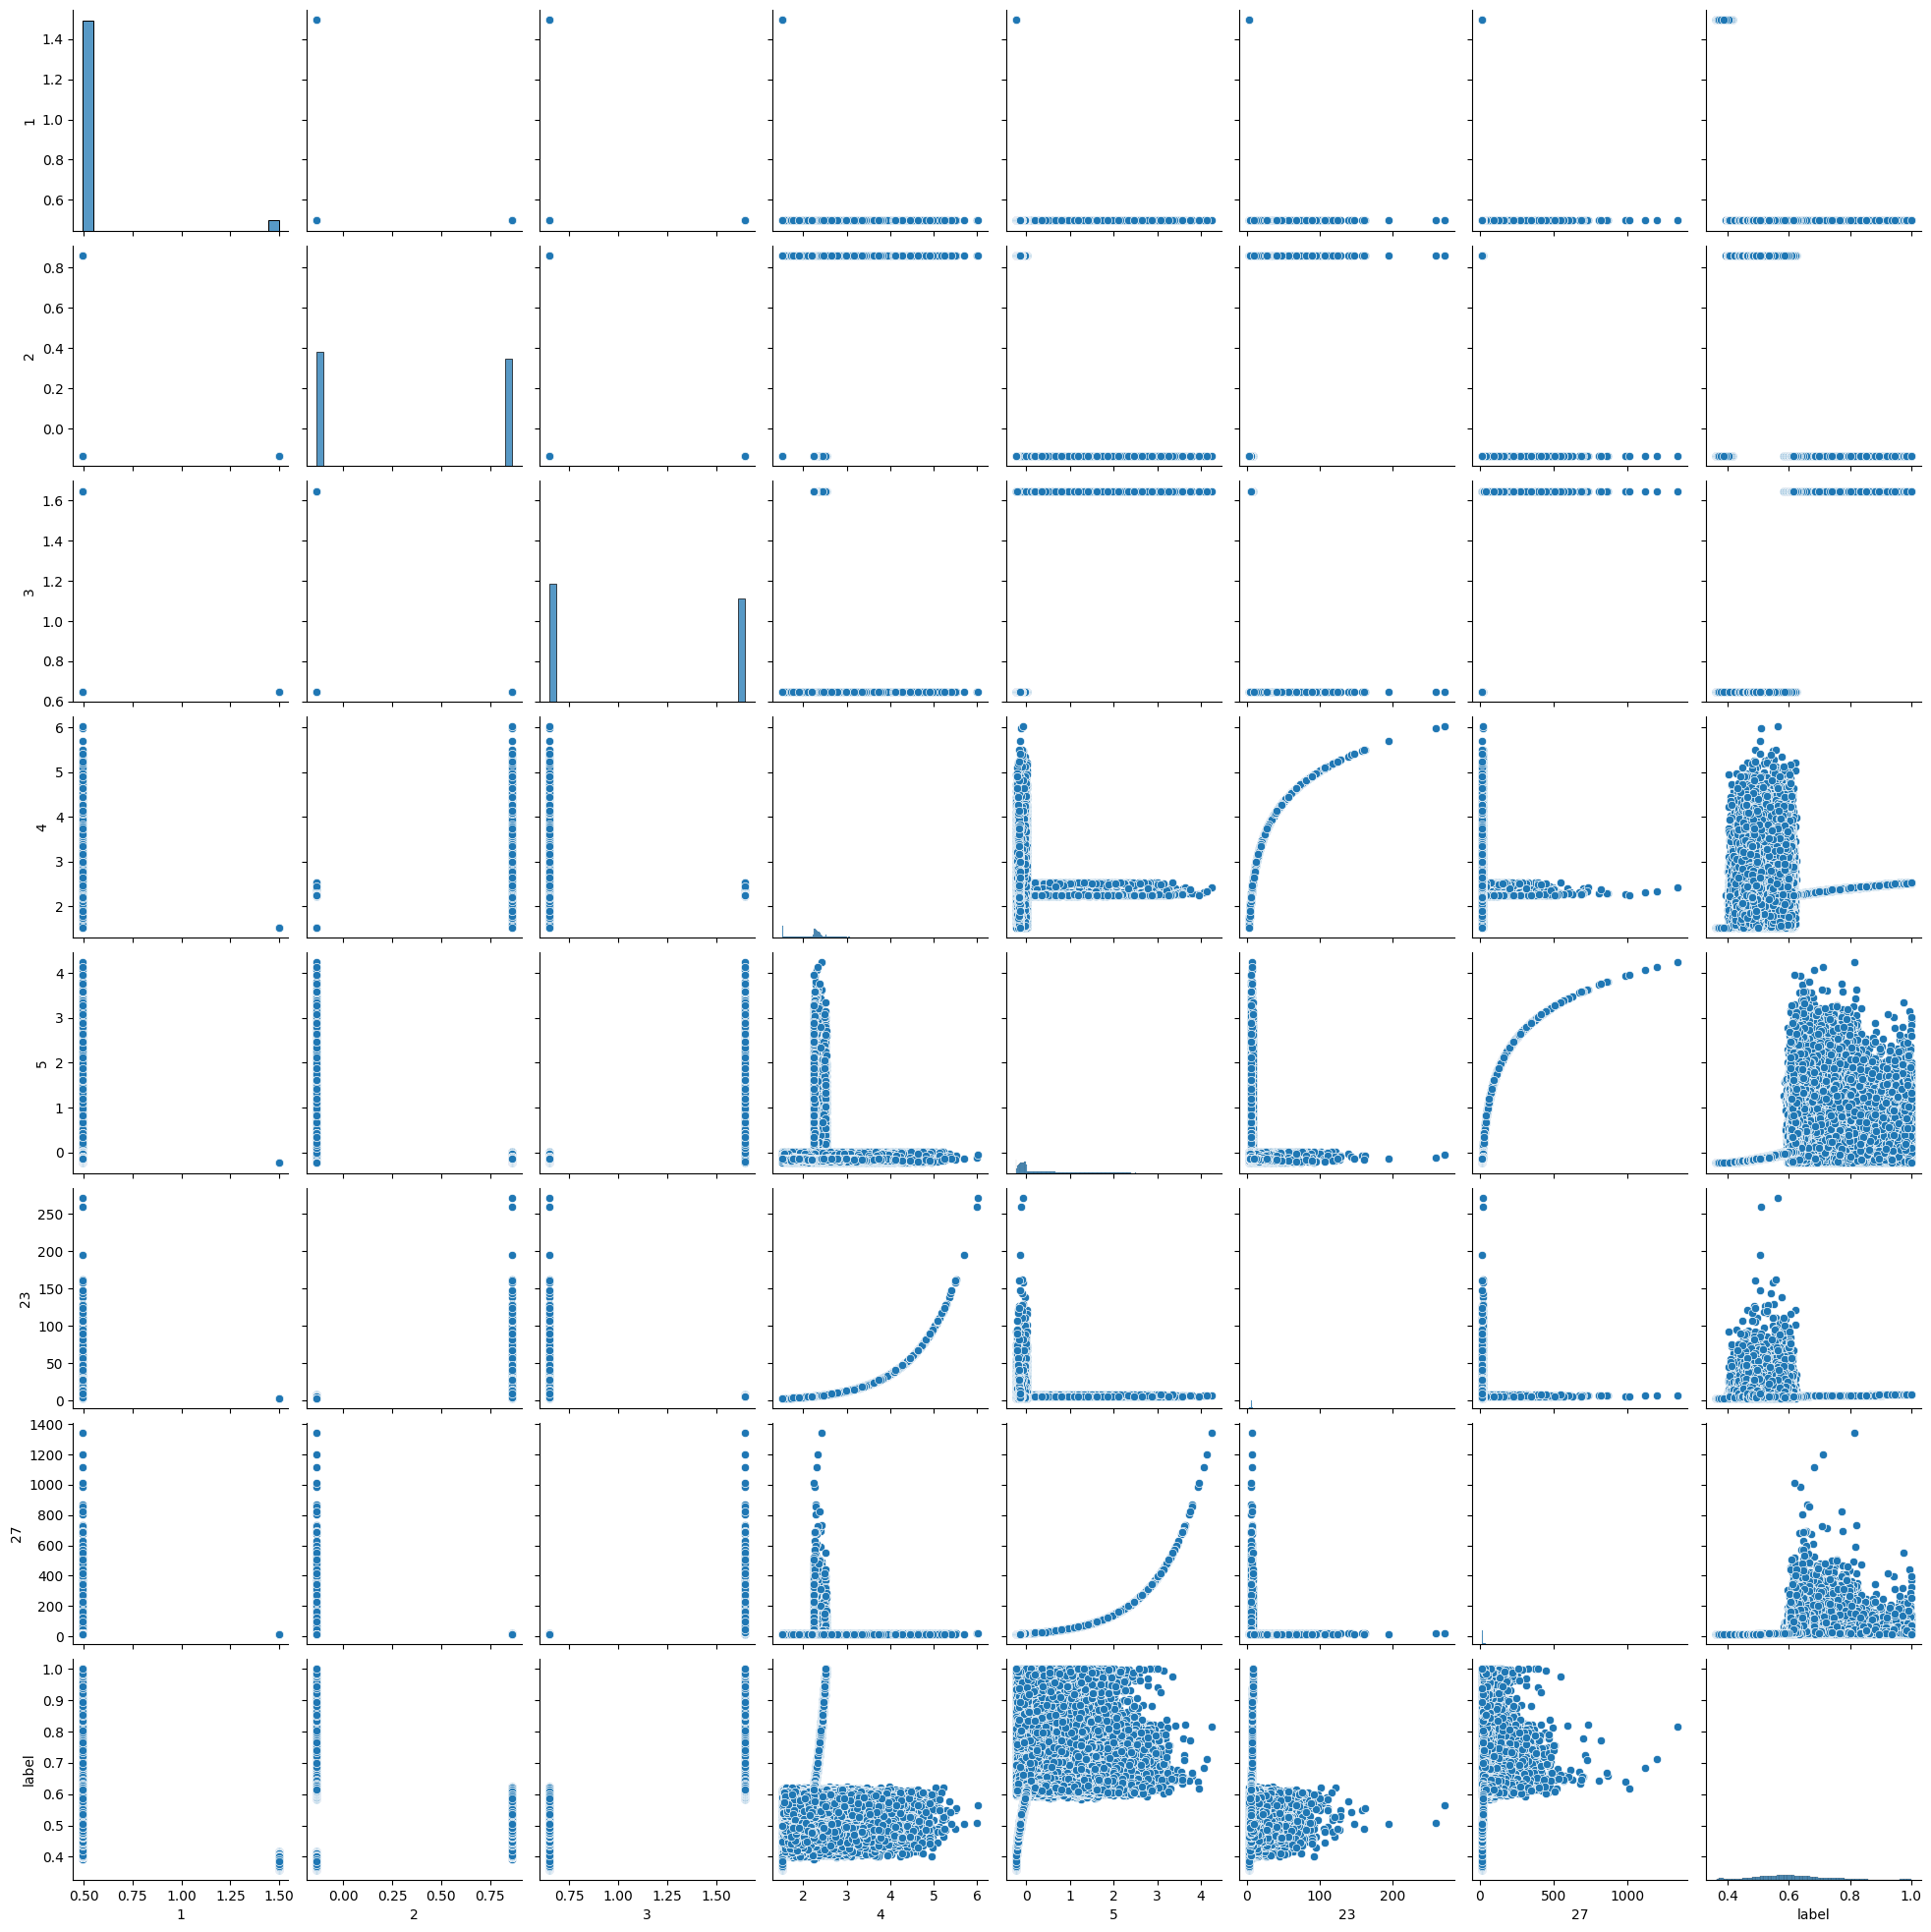

In [67]:
_ = sns.pairplot(pd.concat((X, y), axis=1))

Цифры пихать нельзя, поэтому переименуем

In [68]:
X1 = X[[1, 2, 3, 4, 5]]
X1.columns
X1 = X1.rename(columns = {i: f'col{i}' for i in range(1, 34)})
print(X1.columns)

Index(['col1', 'col2', 'col3', 'col4', 'col5'], dtype='object')


In [139]:
pd.concat((X1, y), axis=1)

,col1,col2,col3,col4,col5,label
0,0.496714,-0.138264,1.647689,2.288549,0.859431,0.658741
1,0.496714,-0.138264,1.647689,2.293655,-0.079660,0.671523
2,0.496714,-0.138264,1.647689,2.296195,1.243614,0.660211
3,0.496714,-0.138264,1.647689,2.296195,0.714635,0.662597
4,0.496714,-0.138264,1.647689,2.288549,0.422087,0.658827
...,...,...,...,...,...,...
172739,0.496714,0.861736,0.647689,2.564834,-0.154069,0.481715
172740,0.496714,0.861736,0.647689,1.774296,-0.147272,0.490861
172741,0.496714,0.861736,0.647689,2.456121,-0.147798,0.490818
172742,0.496714,0.861736,0.647689,1.892871,-0.145478,0.490680


In [140]:
model_new = smf.ols('label ~ col1 + col2 + col3 + col4 + col5', data=pd.concat((X1, y), axis=1)).fit()
model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                 9.121e+04
Date:                Wed, 17 May 2023   Prob (F-statistic):               0.00
Time:                        11:06:06   Log-Likelihood:             2.2475e+05
No. Observations:              172744   AIC:                        -4.495e+05
Df Residuals:                  172739   BIC:                        -4.494e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2058      0.000    566.749      0.000       0.205       0.206
col1          -0.0092      0.001    -16.968      0.000      -0.010      -0.008
col2           0.1305      0.000    287.322      0.000       0.130       0.131
col3           0.2914      0.000    637.786      0.000       0.290       0.292
col4           0.0142      0.000     37.909      0.000       0.014       0.015
col5           0.0087      0.000     22.774      0.000       0.008       0.009
==============================================================================
Omnibus:                    40932.087   Durbin-Watson:                   0.621
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           122965.281
Skew:                           1.229   Prob(JB):                         0.00
Kurtosis:                       6.322   Cond. No.                     1.73e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.65e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [141]:
X_test.rename(columns ={i: f'col{i}' for i in range(6)})

,col1,col2,col3,col4,col5
0,0.496714,0.861736,0.647689,1.930339,-0.096312
1,0.496714,0.861736,0.647689,1.824616,-0.110487
2,0.496714,0.861736,0.647689,2.036428,-0.126482
3,0.496714,0.861736,0.647689,1.661662,-0.123893
4,0.496714,0.861736,0.647689,2.622118,-0.110487
...,...,...,...,...,...
260395,0.496714,0.861736,0.647689,1.850942,-0.038855
260396,0.496714,0.861736,0.647689,3.408925,-0.031862
260397,0.496714,0.861736,0.647689,2.340757,-0.027913
260398,0.496714,0.861736,0.647689,2.955383,-0.033565


In [145]:
X_train.shape, np.load('/content/drive/MyDrive/Colab Notebooks/regression_x_test.npy').shape

((286, 604, 35), (420, 620, 35))

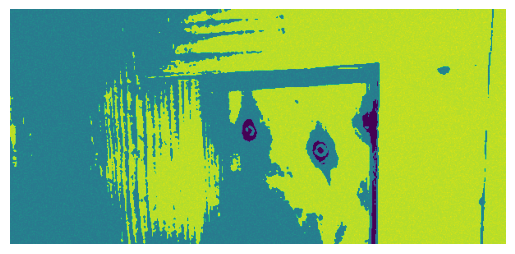

In [154]:
X_test = np.load('/content/drive/MyDrive/Colab Notebooks/regression_x_test.npy')[:286, :604, :]
X_test = X_test.reshape(-1, 35)
X_test = pd.DataFrame(X_test, columns = [i for i in range(1, magic_const+1)]).iloc[:, :5]

pred = model_new.predict(X_test.rename(columns ={i: f'col{i}' for i in range(6)}))
pred = pred.to_numpy().reshape(286, 604)

plt.imshow(pred)
plt.axis('off')
plt.show();

In [ ]:
X = np.load('regression_x_train.npy')
X = X.reshape(-1, 35)
X = pd.DataFrame(X, columns = [i for i in range(1, magic_const+1)])
X1 = X[[1, 2, 3, 4, 5,31,33]]
X1.columns
X1 = X1.rename(columns = {i: f'col{i}' for i in range(1,34)})
print(X1.columns)

Index(['col1', 'col2', 'col3', 'col4', 'col5', 'col31', 'col33'], dtype='object')


In [ ]:
model_new = smf.ols('label ~ col1 * col2 + col3 * col4 +col5 + col31*col33', data=pd.concat((X1, y), axis=1)).fit()
model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                 2.487e+05
Date:                Wed, 17 May 2023   Prob (F-statistic):               0.00
Time:                        01:42:05   Log-Likelihood:             3.3442e+05
No. Observations:              172744   AIC:                        -6.688e+05
Df Residuals:                  172736   BIC:                        -6.687e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.387e+08   1.69e+09     -0.082      0.935   -3.45e+09    3.17e+09
col1         4.404e+08   4.84e+09      0.091      0.927   -9.04e+09    9.92e+09
col2        -2.136e+09   4.75e+09     -0.449      0.653   -1.15e+10    7.18e+09
col1:col2    4.057e+09   7.66e+09      0.530      0.596   -1.09e+10    1.91e+10
col3        -1.205e+08   4.38e+09     -0.028      0.978   -8.71e+09    8.47e+09
col4           -0.7970      0.001   -644.797      0.000      -0.799      -0.795
col3:col4       1.2302      0.002    665.017      0.000       1.227       1.234
col5            0.0088      0.000     43.397      0.000       0.008       0.009
col31       -1.696e+08   1.37e+10     -0.012      0.990   -2.71e+10    2.67e+10
col33        9.637e+06   3.93e+08      0.024      0.980   -7.62e+08    7.81e+08
col31:col33 -3.273e+06   1.06e+08     -0.031      0.975   -2.11e+08    2.04e+08
==============================================================================
Omnibus:                    12961.334   Durbin-Watson:                   0.591
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20882.977
Skew:                          -0.584   Prob(JB):                         0.00
Kurtosis:                       4.239   Cond. No.                     3.48e+29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.27e-53. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

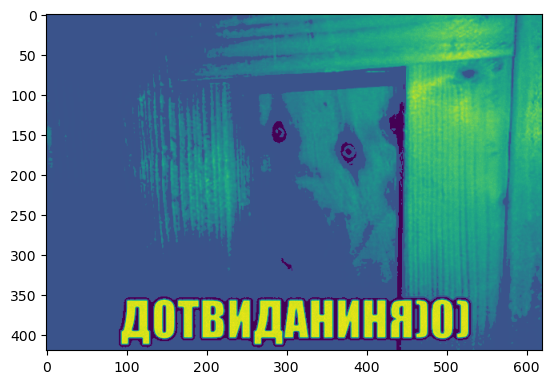

In [ ]:
X = np.load('regression_x_train.npy')
Y = np.load('regression_y_train.npy')
test = np.load('regression_x_test.npy')
test = test.reshape(-1, 35)
test = pd.DataFrame(test, columns = [i for i in range(1, magic_const+1)])
pred = model_new.predict(test.rename(columns ={i: f'col{i}' for i in range(1, 34)}))
Y = np.reshape(pred.values, (-1, X_test.shape[1]))

plt.imshow(Y)
plt.show()

### Cпойлер

Совсем не тот результат, который ожидался. 


1) Признаки 31 и 33 неинформативны, так как состоят из константых значений. То есть их можно просто выкинуть
2) Модель суммы плоха и надо брать хитрую комбинацию попарных произведений label ~ col1 + col2 * col4 + col3 * col5

Без этих вещей получается результат выше

In [156]:
X = np.load('/content/drive/MyDrive/Colab Notebooks/regression_x_train.npy')
X = X.reshape(-1, 35)
X = pd.DataFrame(X, columns = [i for i in range(1, magic_const+1)])
X1 = X[[1, 2, 3, 4, 5]]
X1.columns
X1 = X1.rename(columns = {i: f'col{i}' for i in range(1,6)})
print(X1.columns)

Index(['col1', 'col2', 'col3', 'col4', 'col5'], dtype='object')


In [157]:
model_new = smf.ols('label ~ col1+col2 / col3+col4/col5 ', data=pd.concat((X1, y), axis=1)).fit()
model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                 9.169e+04
Date:                Wed, 17 May 2023   Prob (F-statistic):               0.00
Time:                        11:11:06   Log-Likelihood:             2.2505e+05
No. Observations:              172744   AIC:                        -4.501e+05
Df Residuals:                  172739   BIC:                        -4.500e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7508      0.001    662.515      0.000       0.749       0.753
col1          -0.2720      0.001   -328.046      0.000      -0.274      -0.270
col2          -0.0110      0.000    -44.249      0.000      -0.011      -0.010
col2:col3     -0.1873      0.000   -594.874      0.000      -0.188      -0.187
col4           0.0147      0.000     39.161      0.000       0.014       0.015
col4:col5      0.0055      0.000     33.658      0.000       0.005       0.006
==============================================================================
Omnibus:                    40975.574   Durbin-Watson:                   0.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           123655.141
Skew:                           1.229   Prob(JB):                         0.00
Kurtosis:                       6.337   Cond. No.                     2.09e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.8e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

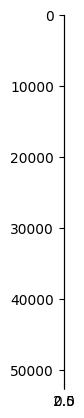

In [159]:
X = np.load('/content/drive/MyDrive/Colab Notebooks/regression_x_train.npy')
Y = np.load('/content/drive/MyDrive/Colab Notebooks/regression_y_train.npy')
test = np.load('/content/drive/MyDrive/Colab Notebooks/regression_x_test.npy')
test = test.reshape(-1, 35)
test = pd.DataFrame(test, columns = [i for i in range(1, magic_const+1)])
pred = model_new.predict(test.rename(columns ={i: f'col{i}' for i in range(1, 6)}))
test_Y = np.reshape(pred.values, (-1, X_test.shape[1]))

plt.imshow(test_Y)
plt.show()

In [160]:
model_new = smf.ols('label ~ col1 + col2 * col4 + col3 * col5', data=pd.concat((X1, y), axis=1)).fit()
model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.631e+06
Date:                Wed, 17 May 2023   Prob (F-statistic):               0.00
Time:                        11:11:47   Log-Likelihood:             5.4518e+05
No. Observations:              172744   AIC:                        -1.090e+06
Df Residuals:                  172737   BIC:                        -1.090e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0914   9.13e-05   1000.329      0.000       0.091       0.092
col1          -0.2988      0.000  -1377.549      0.000      -0.299      -0.298
col2           1.6176      0.001   2448.764      0.000       1.616       1.619
col4           1.0599      0.000   2265.223      0.000       1.059       1.061
col2:col4     -1.2300      0.001  -2252.200      0.000      -1.231      -1.229
col3          -1.1355      0.001  -1845.142      0.000      -1.137      -1.134
col5           1.2385      0.001   1351.690      0.000       1.237       1.240
col3:col5     -0.7516      0.001  -1344.958      0.000      -0.753      -0.751
==============================================================================
Omnibus:                    28509.516   Durbin-Watson:                   1.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            97130.865
Skew:                           0.829   Prob(JB):                         0.00
Kurtosis:                       6.278   Cond. No.                     3.01e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.71e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

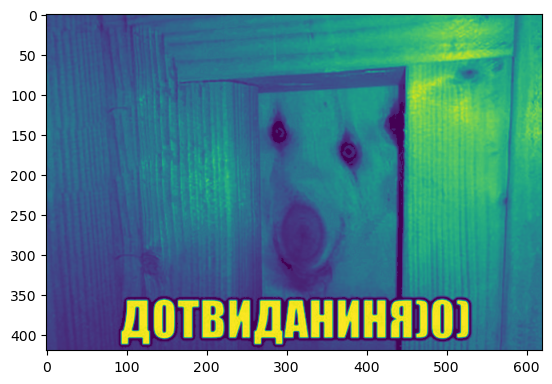

In [ ]:
X = np.load('regression_x_train.npy')
Y = np.load('regression_y_train.npy')
test = np.load('regression_x_test.npy')
test = test.reshape(-1, 35)
test = pd.DataFrame(test, columns = [i for i in range(1, magic_const+1)])
pred = model_new.predict(test.rename(columns ={i: f'col{i}' for i in range(1, 6)}))
Y = np.reshape(pred.values, (-1, X_test.shape[1]))

plt.imshow(Y)
plt.show()

В результате анализа признаков и построения регрессии получен способ качественной обработки изображений при заданной кодировке. Другими словами, если у нас есть массив закодированных картинок со специальным форматом, то их можно декодировать достаточно простым и эффективным способом.

Дотвиданиня)0)